In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from feat import FuelEstimator, MassEstimator
from openap import aero

In [3]:
ac_type = "A320"
flight_profiles = pd.read_pickle("fp.pkl")
me = MassEstimator(ac_type=ac_type)
mass = me.reference_mass

In [5]:
fe = FuelEstimator(ac_type=ac_type, mass=mass)
f_trip = fe.compute_fuel_per_flight(flight_profiles.query("id==0")).fc.item()
landing_mass = mass - f_trip
f_cont = f_trip * 0.05
f_trip, mass, landing_mass, f_cont

(2476.8965578418165, 67380.0, 64903.103442158186, 123.84482789209083)

In [5]:
from openap.traj import Generator

trajgen = Generator(ac=ac_type, eng=None)
cruise = trajgen.cruise(dt=30 * 60, alt_cr=1500, random=True)
cruise = dict(
    (key, value[:2] if isinstance(value, np.ndarray) else value)
    for key, value in cruise.items()
)
cruise = pd.DataFrame.from_dict(cruise).assign(id=0, fp="CR")
cruise

,t,h,s,v,vs,alt_cr,mach_cr,id,fp
0,0.0,457.2,0.000000,254.561052,0.0,1500,0.75195,0,CR
1,1800.0,457.2,458209.893362,254.561052,0.0,1500,0.75195,0,CR


In [20]:
from feat import FlightProfileGenerator

fpg = FlightProfileGenerator(ac_type=ac_type)
cruise = fpg.gen_cruise_for_fuel_reserve()

fe = FuelEstimator(ac_type=ac_type, mass=landing_mass)
f_reserve = fe.compute_fuel_per_flight(cruise).fc.item()
f_reserve

3154.213437335996

In [18]:
from feat.fuel import compute_fuel_reserve

compute_fuel_reserve(ac_type, eng_type=None, mass=landing_mass)

3104.4337397161053

350.41633690488726


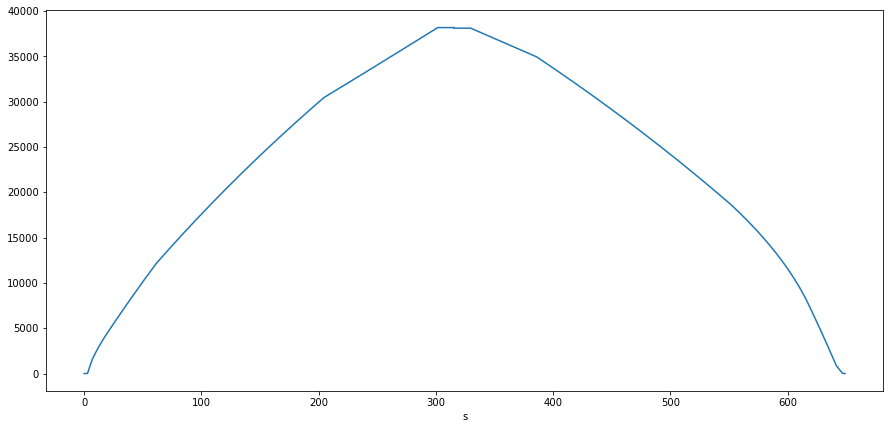

In [132]:
from openap import aero
from openap.traj import Generator

trajgen = Generator(ac=ac_type, eng=None)
traj_alt = trajgen.complete(dt=10, range_cr=0, random=True)
traj_alt = pd.DataFrame.from_dict(traj_alt).assign(id=0)
traj_alt
print(traj_alt.s.iloc[-1] / aero.nm)

fig, ax = plt.subplots(figsize=(15, 7))
for (_, fp) in traj_alt.assign(h=traj_alt.h / aero.ft, s=traj_alt.s / 1e3).groupby(
    "id"
):
    fp.plot(x="s", y="h", ax=ax, legend=False)

In [8]:
from feat import FlightProfileGenerator

fpg = FlightProfileGenerator(ac_type=ac_type)
traj_alt = fpg.gen_flight_for_alternate_fuel()

fe = FuelEstimator(ac_type=ac_type, mass=landing_mass)
f_alt = fe.compute_fuel_per_flight(traj_alt).fc.item()
f_alt

1401.0258455479648

In [9]:
flight_profiles.query("id==0").s.iloc[-1] / aero.nm, traj_alt.s.iloc[-1] / aero.nm

(541.5264915146265, 320.79344032601125)

In [10]:
from feat.fuel import compute_fuel_alternate

compute_fuel_alternate(ac_type, eng_type=None, mass=landing_mass)

1474.581801065618

In [4]:
passenger_luggage_mass = 100  # Kg
avg_num_seats = 150  # A320
avg_load_factor = 0.819  # in 2018
m_payload = avg_load_factor * avg_num_seats * passenger_luggage_mass
m_payload

12285.0

In [8]:
from feat import FlightProfileGenerator
from feat.fuel import compute_fuel_trip, compute_fuel_reserve, compute_fuel_alternate

fpg = FlightProfileGenerator(ac_type=ac_type, eng_type=None)
flight_profile = flight_profiles.query("id==0")
me = MassEstimator(ac_type=ac_type)
oew, tow = me.oew, me.reference_mass

while True:
    f_trip = compute_fuel_trip(
        ac_type, eng_type=None, mass=tow, flight_profile=flight_profile
    )
    f_cont = f_trip * 0.05
    landing_mass = mass - f_trip
    f_res = compute_fuel_reserve(fpg, mass=landing_mass)
    f_alt = compute_fuel_alternate(fpg, mass=landing_mass)
    m_fuel = f_trip + f_cont + f_res + f_alt
    new_tow = oew + m_payload + m_fuel
    print(f_trip, f_cont, f_res, f_alt, m_fuel, tow, new_tow)
    if abs(tow - new_tow) < 10:
        break
    tow = new_tow

2476.8965578418165 123.84482789209083 3089.0017192744385 1355.4212271054494 7045.164332113795 67380.0 61930.164332113796
2476.8965578418165 123.84482789209083 3368.3508415904034 1422.8681417899911 7391.960369114302 61930.164332113796 62276.9603691143
2476.8965578418165 123.84482789209083 3050.3143979406373 1534.4279891388558 7185.483772813401 62276.9603691143 62070.4837728134
2476.8965578418165 123.84482789209083 3339.1880011292174 1451.503445457007 7391.432832320132 62070.4837728134 62276.43283232013
2476.8965578418165 123.84482789209083 3216.8777285531155 1572.1410678936606 7389.760182180684 62276.43283232013 62274.76018218068
